In [1]:
root_path = '../dataset'

In [2]:
import os
import numpy as np
import pandas as pd

IMAGE_DIR = os.path.join(root_path, 'ISIC_2019_Training_Input')
panda_path = os.path.join(root_path, 'ISIC_2019_Training_GroundTruth.csv')

In [3]:
print(len(os.listdir(IMAGE_DIR)))

25333


In [4]:
print(f'This is the image dir: {IMAGE_DIR}')
print(f'This is the csv filepath: {panda_path}')

This is the image dir: ../dataset\ISIC_2019_Training_Input
This is the csv filepath: ../dataset\ISIC_2019_Training_GroundTruth.csv


In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import preprocess_input, VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

In [6]:
def preprocess(df):
  for index, img in enumerate(df.image):
    img = img+'.jpg'
    df.image[index]=img
  df.drop(['UNK'], axis=1, inplace=True)

In [7]:
def train_val_test_split(df, test_len=1000, val_ratio=0.2):
  test_rows = (np.random.rand(1000)*df.shape[0]).astype(int)
  test_df =  df.iloc[test_rows]
  test_df = test_df.reset_index().drop(['index'], axis=1)
  df.drop(test_rows, axis=0, inplace=True)
  df = df.reset_index().drop(['index'], axis=1)
  val_rows = (np.random.rand(int(val_ratio*df.shape[0]))*df.shape[0]).astype(int)
  val_df = df.iloc[val_rows]
  df.drop(val_rows, axis=0, inplace=True)
  test_df = test_df.reset_index().drop(['index'], axis=1)
  df = df.reset_index().drop(['index'], axis=1)
  return df, val_df, test_df


In [8]:
full_df = pd.read_csv(panda_path)
preprocess(full_df)
train_df, val_df, test_df = train_val_test_split(full_df)
labels=list(train_df.columns[1:])
print(labels)
train_df.head()

C:\Users\User\AppData\Local\Temp\ipykernel_21616\3569353137.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.image[index]=img
C:\Users\User\AppData\Local\Temp\ipykernel_21616\3569353137.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.image[index]=img
C:\Users\User\AppData\Local\Temp\ipykernel_21616\3569353137.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.image[index]=img
C:\Users\User\AppData\Local\Temp\ipykernel_

['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']


image  MEL   NV  BCC   AK  BKL   DF  VASC  SCC
0  ISIC_0000000.jpg  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0
1  ISIC_0000002.jpg  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0
2  ISIC_0000004.jpg  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0
3  ISIC_0000006.jpg  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0
4  ISIC_0000007.jpg  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0

In [9]:
def basic_vgg(input_shape=(224, 224, 3), num_classes=8):
  new_input = Input(shape=input_shape)
  model = VGG16(weights=None, input_tensor=new_input, classes=num_classes)
  model.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [10]:
base_model = basic_vgg()
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
#sequential API
def vgg_model(input_shape=(224, 224, 3)):
  model = Sequential()
  model.add(VGG16(include_top=False, weights='imagenet', input_shape=input_shape))
  
  model.add(GlobalAveragePooling2D())
  #model.add(Flatten())

  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.25))

  model.add(Dense(1024))
  model.add(BatchNormalization())
  model.add(Activation('relu')) 
  model.add(Dropout(0.5))

  model.add(Dense(8, activation='sigmoid'))
  model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
  print('Model has compiled')
  return model

In [12]:
vgg16_model = vgg_model(input_shape=(224, 224, 3))

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 6d6bbae143d832006294945121d1f1fc so we will re-download the data.
58889256/58889256 [==============================] - 64s 1us/step
Model has compiled


In [13]:
vgg16_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1024)              525312    
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                         

In [14]:
def get_train_gen(df, img_path=IMAGE_DIR, target_size=(224, 224)):
  data_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                horizontal_flip=True,
                                width_shift_range=0.2,
                                height_shift_range=0.2)
  return data_gen.flow_from_dataframe(dataframe=df, directory=img_path, 
                                      x_col='image', y_col=list(df.columns)[1:],
                                      batch_size=64, shuffle=True, class_mode='raw', 
                                      target_size=target_size)

def get_val_test_gen(val_df, test_df, img_path=IMAGE_DIR, target_size=(224, 224)):
  data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
  val = data_gen.flow_from_dataframe(dataframe=val_df, directory=img_path, 
                                      x_col='image', y_col=list(val_df.columns)[1:],
                                      batch_size=64, shuffle=True, class_mode='raw', 
                                      target_size=target_size)
  test = data_gen.flow_from_dataframe(dataframe=test_df, directory=img_path, 
                                      x_col='image', batch_size=1, shuffle=True, class_mode=None, 
                                      target_size=target_size)
  return val, test

In [15]:
train_generator = get_train_gen(train_df)
valid_generator, test_generator = get_val_test_gen(val_df, test_df)

Found 19920 validated image filenames.
Found 4869 validated image filenames.
Found 1000 validated image filenames.


In [16]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
history = vgg16_model.fit(train_generator, steps_per_epoch=STEP_SIZE_TRAIN, validation_data=valid_generator,
                        validation_steps=STEP_SIZE_VALID, epochs=10)

Epoch 1/10
311/311 [==============================] - 12448s 40s/step - loss: 0.3658 - accuracy: 0.4957 - val_loss: 0.2487 - val_accuracy: 0.5964
Epoch 2/10
311/311 [==============================] - 12491s 40s/step - loss: 0.2289 - accuracy: 0.6217 - val_loss: 0.2249 - val_accuracy: 0.6435
Epoch 3/10
311/311 [==============================] - 12518s 40s/step - loss: 0.2072 - accuracy: 0.6542 - val_loss: 0.1913 - val_accuracy: 0.6674
Epoch 4/10
311/311 [==============================] - 12472s 40s/step - loss: 0.1933 - accuracy: 0.6750 - val_loss: 0.1974 - val_accuracy: 0.6604
Epoch 5/10
311/311 [==============================] - 12708s 41s/step - loss: 0.1841 - accuracy: 0.6875 - val_loss: 0.1854 - val_accuracy: 0.6832
Epoch 6/10
311/311 [==============================] - 12668s 41s/step - loss: 0.1723 - accuracy: 0.7122 - val_loss: 0.1831 - val_accuracy: 0.6883
Epoch 7/10
311/311 [==============================] - 12697s 41s/step - loss: 0.1642 - accuracy: 0.7263 - val_loss: 0.1722 -

In [17]:
#copied from Coursera util package
from keras.preprocessing import image
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.compat.v1.logging import INFO, set_verbosity
import cv2

def get_roc_curve(labels, predicted_vals, generator):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = generator.labels[:, i]
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.show()
    return auc_roc_vals

In [18]:
preds = vgg16_model.predict_generator(valid_generator)

C:\Users\User\AppData\Local\Temp\ipykernel_21616\1735744877.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = vgg16_model.predict_generator(valid_generator)


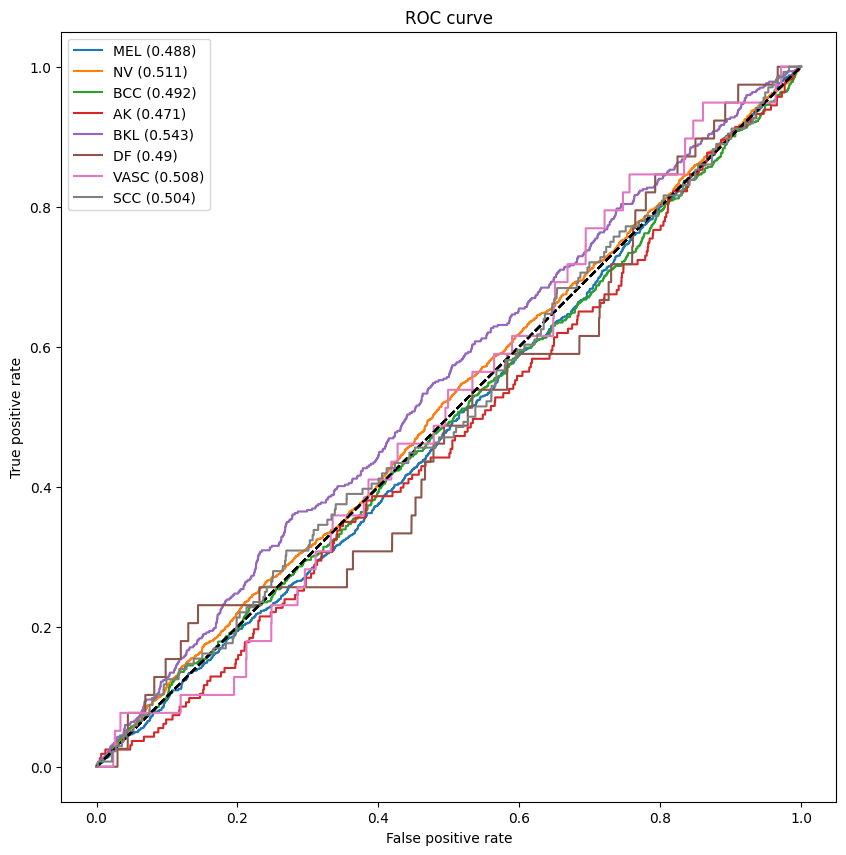

In [19]:
import matplotlib.pyplot as plt
auc_rocs = get_roc_curve(labels, preds, valid_generator)


In [20]:
#From ONODERA Notebook
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    Refer to: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, fontsize=25)
    plt.yticks(tick_marks, fontsize=25)
    plt.xlabel('Predicted label',fontsize=25)
    plt.ylabel('True label', fontsize=25)
    plt.title(title, fontsize=30)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size="5%", pad=0.15)
    cbar = ax.figure.colorbar(im, ax=ax, cax=cax)
    cbar.ax.tick_params(labelsize=20)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
#            title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    fontsize=20,
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [21]:
plot_confusion_matrix(valid_generator.labels, preds, labels, title='Skin Disease Confusion Matrix')

NameError: name 'confusion_matrix' is not defined